# 9주차 Cleansing
데이터는 분석이나 학습에 사용하기에 적합한 형태로 존재하지 않을 수 있으므로, 그런 데이터를 분석에 적합하게 변환하거나 정리하는 과정
1. 데이터 누락(NA) 파악 및 처리
2. 이상치(Outliers) 파악 및 처리
3. 불필요한 데이터 파악 및 제거
4. 데이터를 일관성 있게 수정

In [1]:
# 라이브러리
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.pyplot import figure

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import ClusterCentroids
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek

In [ ]:
### 성과지표 왜곡 ###
# 전체 데이터로 예측했을 때 vs 한가지로만 예측했을 때 -> 별로 차이 안남

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2%}".format(accuracy))


### 혼동 행렬로 확인 ###
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)
print("Precision: {:.2%}".format(precision_score(y_test, y_pred)))
print("Recall: {:.2%}".format(recall_score(y_test, y_pred)))
print("F1: {:.2%}".format(f1_score(y_test, y_pred)))
print("ROC AUC: {:.2%}".format(roc_auc_score(y_test, y_pred)))


### 랜덤포레스트로 확인 ###
rnd_clf = RandomForestClassifier(
    n_estimators = 500,  
    max_features = 'auto', 
    max_samples=0.5,    
    bootstrap = True,
    n_jobs=-1
)
scores = cross_val_score(rnd_clf, X_rus, y_rus, scoring='roc_auc', cv=5)
print('ROC AUC: {:.3}'.format(scores.mean()))

## 1. 데이터 누락(NA) 파악 및 처리
- 데이터에 누락된 값(NA)이 포함됐을 때 에러 발생
- NA 값이 포함된 행을 제외하거나 NA 값을 다른 값으로 변환해야함
- NA 값을 포함한 행 찾기: isnull()

In [ ]:
### 1. NA 값 존재 여부 찾기 ###

# 1.1 Heatmap 사용
cols = df.columns[:30] 
colours = ['blue', 'yellow'] # 노랑 - 누락. 파랑 - 정상.
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))


# 1.2 누락 데이터 비율 리스트
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))


# 1.3 누락 데이터 히스토그램
for col in df.columns:
    missing = df[col].isnull()
    num_missing = np.sum(missing)
    
    if num_missing > 0:  
        #print('created missing indicator for: {}'.format(col))
        df['{}_ismissing'.format(col)] = missing

ismissing_cols = [col for col in df.columns if 'ismissing' in col]
df['num_missing'] = df[ismissing_cols].sum(axis=1)
df['num_missing'].value_counts().reset_index().sort_values(by='index').plot.bar(x='index', y='num_missing')

In [ ]:
### 2. 누락 데이터 처리 ###

# 누락 데이터를 포함한 행 제거 (한 행에서 누락데이터가 35개 이상인 행 제거)
ind_missing = df[df['num_missing'] > 35].index
df_less_missing_rows = df.drop(ind_missing, axis=0)


# 누락 데이터가 많은 컬럼 제거
cols_to_drop = ['hospital_beds_raion']
df_less_hos_beds_raion = df.drop(cols_to_drop, axis=1)


# 누락된 데이터를 다른 값으로 대체 (fillna() 사용)
med = df['life_sq'].median()
print(med)
df['life_sq'] = df['life_sq'].fillna(med)


# 수치형 변수에서 누락된 경우 중앙값으로 대체

df_numeric = df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values

for col in numeric_cols:
    missing = df[col].isnull()
    num_missing = np.sum(missing)
    
    if num_missing > 0:  
        print('imputing missing values for: {}'.format(col))
        df['{}_ismissing'.format(col)] = missing
        med = df[col].median()
        df[col] = df[col].fillna(med)
        
        
# 범주형 변수의 경우 가장 빈번하게 나타나는 범주로 누락값 대체

df_non_numeric = df.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values

for col in non_numeric_cols:
    missing = df[col].isnull()
    num_missing = np.sum(missing)
    
    if num_missing > 0:  
        print('imputing missing values for: {}'.format(col))
        df['{}_ismissing'.format(col)] = missing
        
        top = df[col].describe()['top'] 
        df[col] = df[col].fillna(top)
        
    
    
# NA로 입력되어 있으면 다루기가 번거롭기에 특정 수치나 범주로 대체
# 예를 들어 수치 -999, 범주 _MISSING_ 으로 대체

# categorical
df['sub_area'] = df['sub_area'].fillna('_MISSING_')

# numeric
df['life_sq'] = df['life_sq'].fillna(-999)

## 2. 이상치 (Outliers) 파악 및 처리
- 이상치: 한 변수의 값이 가지는 패턴에서 벗어난 아주 크거나 작은 값
- 이상치는 평균의 왜곡을 불러옴

In [ ]:
### 히스토그램으로 찾기 ###
df['colname'].hist(bins=100)

### 박스 플롯으로 찾기 ###
df.boxplot(column=['colname'])

### 기술 통계치에서 발견하기 ###
df['colname'].describe()

## 3. 불필요한 데이터 파악 및 처리

In [ ]:
### 반복되는 값이 많은 변수 ###
# 변수 값 중 95%이상이 동일한 경우, 의미있는 변수로 보기 어려움

num_rows = len(df.index)
low_information_cols = [] 

for col in df.columns:
    cnts = df[col].value_counts(dropna=False)
    top_pct = (cnts/num_rows).iloc[0]
    
    if top_pct > 0.95:
        low_information_cols.append(col)
        print('{0}: {1:.5f}%'.format(col, top_pct*100))
        print(cnts)
        print()
        

### 중복 데이터 제거 ###
# 10 행의 데이터가 중복
# 'id' 컬럼을 제외하고 (id는 행 마다 다르므로)
# drop_duplicates()로 중복되는 행 제거

df_dedupped = df.drop('id', axis=1).drop_duplicates()

print(df.shape)
print(df_dedupped.shape)

## 4. 데이터를 일관성 있게 수정

In [ ]:
### 대소문자 사용 통일: 모두 소문자로 ###
df['sub_area'].value_counts(dropna=False)
df['sub_area_lower'] = df['sub_area'].str.lower()
df['sub_area_lower'].value_counts(dropna=False)


### 형식 변환 ###
df['timestamp_dt'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d')
df['year'] = df['timestamp_dt'].dt.year
df['month'] = df['timestamp_dt'].dt.month
df['weekday'] = df['timestamp_dt'].dt.weekday

print(df['year'].value_counts(dropna=False))
print()
print(df['month'].value_counts(dropna=False))

## 데이터 불균형

In [ ]:
### 불균형 확인 ###
target_count = df.TenYearCHD.value_counts()

print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)', color=['blue','orange'])

## 언더 샘플링, 오버 샘플링

### 언더 샘플링
- 상대적으로 데이터가 많은 범주에서 무작위로 데이터를 제외하여 두 범주 데이터 수의 균형을 맞춤
- 데이터를 제거하기 때문에 정보 손실 발생

### 오버 샘플링
- 상대적으로 데이터가 적은 범주의 데이터를 무작위로 중복 추가하여 두 범주 데이터 수의 균형을 맞춤
- 데이터를 중복해서 사용하기 때문에 과적합 발생이 쉬움

In [ ]:
# Class count
count_class_0, count_class_1 = heart.TenYearCHD.value_counts()
print("count_class_0:", count_class_0)
print("count_class_1:", count_class_1)

# Divide by class
df_class_0 = heart[heart.TenYearCHD == 0]
df_class_1 = heart[heart.TenYearCHD == 1]


### 언더샘플링 ###
df_class_0_under = df_class_0.sample(count_class_1)
df_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_under.TenYearCHD.value_counts())

df_under.TenYearCHD.value_counts().plot(kind='bar', title='Count (target)', color=['blue','orange'])


### 오버샘플링 ###
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_over.TenYearCHD.value_counts())

df_over.TenYearCHD.value_counts().plot(kind='bar', title='Count (target)', color=['blue','orange'])

### imbalanced-learn

In [ ]:
### 언더샘플링 ###
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_sample(X, y)
y_rus.value_counts().plot(kind='bar', title='Count (target)', color=['blue','orange'])


### 오버샘플링 ###
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X, y)
print(X_ros.shape[0] - X.shape[0], 'new random picked points')
y_ros.value_counts().plot(kind='bar', title='Count (target)', color=['blue','orange'])

### Tomek links (오버샘플링)
- 분류하고자 하는 두 범주 데이터가 매우 근접하게 쌍으로 존재하는 경우
- Tomek links에서 더 많이 분포하는 범주의 데이터 제거

In [ ]:
tl = TomekLinks(sampling_strategy='majority')
X_tl, y_tl = tl.fit_sample(X, y)

y_tl.value_counts().plot(kind='bar', title='Count (target)', color=['blue','orange'])

### Kmeans 군집화 중앙값 (언더샘플링)
- 다수의 데이터가 포함된 범주의 데이터를 Kmeans 군집화를 이용해 N개의 클러스터 형성
- N개의 클러스터의 중앙값이 샘플링된 새로운 데이터

In [ ]:
cc = ClusterCentroids()
X_cc, y_cc = cc.fit_sample(X, y)

y_cc.value_counts().plot(kind='bar', title='Count (target)', color=['blue','orange'])

### SMOTE (오버 샘플링)
- 적은 수의 범주 데이터를 이용해서 합성 데이터를 생성, 적은 수의 범주 데이터 중에서 무작위로 선택하고 최근접 이웃 데이터를 고려하여 새로운 데이터를 합성하여 생성

In [ ]:
smote = SMOTE()
X_sm, y_sm = smote.fit_sample(X, y)

y_sm.value_counts().plot(kind='bar', title='Count (target)', color=['blue','orange'])

### ADASYN(Adaptive Synthetic Sampling)
- 합성 데이터를 생성하는 방안, 적은 데이터분포에 반비례하여 합성데이터 생성
- 적은 범주의 데이터가 적게 분포하는 곳에 더 많은 합성 데이터가 생기며, 적은 범주의 데이터가 많이 분포하는 곳에 합성 데이터가 적게 생김

In [ ]:
ada = ADASYN()
X_ada, y_ada = ada.fit_sample(X, y)

y_ada.value_counts().plot(kind='bar', title='Count (target)', color=['blue','orange'])

### SMOTETomek (언더샘플링 -> 오버샘플링)
- 언더 샘플링 수행 후 오버 샘플링
- Tomek links -> SMOTE
- Tomek links를 통해 두 범주가 구분되는 간격 더 넓게 확보 -> 적게 분포하는 데이터를 SMOTE로 오버샘플링

In [ ]:
smt = SMOTETomek()
X_smt, y_smt = smt.fit_sample(X, y)

y_smt.value_counts().plot(kind='bar', title='Count (target)', color=['blue','orange'])

### scikit learn 리샘플링

In [ ]:
from sklearn.utils import resample

df_majority = card[card.Class==0]
df_minority = card[card.Class==1]

df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=len(df_minority),     # to match minority class
                                ) 

# 10주차 TextMining
- 특정한 목적에 대해 의미 있는 정보만 추출하고 일련의 텍스트 분석 및 처리과정을 통해 이루어진다

In [ ]:
# 라이브러리
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer, LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk import Text
from nltk import FreqDist

from wordcloud import WordCloud

import konlpy 
from konlpy.corpus import kolaw
from konlpy.tag import *
from matplotlib import font_manager, rc

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB


In [ ]:
sent_tokenize(data.Texts[0])   # 문장분리
word_tokenize(data.Texts[0])   # 단어분리

retokenize = RegexpTokenizer("[\w]+")   # 문장기호 제거
retokenize.tokenize(data.Texts[0])

data["tokenized_sents"] = data.apply(
    lambda row: nltk.word_tokenize(str(row["Texts"])), axis=1)
data['sents_length'] = data.apply(
    lambda row: len(row['tokenized_sents']), axis=1)
data.head()


## 어간 추출 Stemming ##
st1 = PorterStemmer()
st2 =  LancasterStemmer()
words = ["fly", "flies", "flying", "flew", "flown"]
print("Porter Stemmer   :", [st1.stem(w) for w in words])
print("Lancaster Stemmer:", [st2.stem(w) for w in words])


## 표제어 추출 Lemmatizing ##
lm = WordNetLemmatizer()
[lm.lemmatize(w, pos="v") for w in words]


## 품사 추출 part of speech ##
nltk.help.upenn_tagset("VB")
tagged_list = pos_tag(word_tokenize(mobile.Texts[0]))
print(tagged_list)
nouns_list = [t[0] for t in tagged_list if t[1] == "NN"]   # 명사만
print(nouns_list)


## 빈도 추출 ##
text = Text(retokenize.tokenize(str(data.Texts)))
text.plot(20)
plt.show()



## 
text.dispersion_plot([])  # 명사만 추출한거
text.concordance("phone")



## 불용어 제외 ##
stopwords = ['I', 'i', 'this', 'the', 'a']
data_tokens = pos_tag(retokenize.tokenize(str(data.Texts)))

names_list = [t[0] for t in data_tokens if t[1] 
              == "NN" and t[0] not in stopwords]

fd_names = FreqDist(names_list)
fd_names.N(), fd_names["phone"], fd_names.freq("phone")
fd_names.most_common(5)

## 워드 클라우드

In [ ]:
wc = WordCloud(width=1000, height=600, background_color="white", random_state=0)
plt.imshow(wc.generate_from_frequencies(fd_names))
plt.axis("off")
plt.show()

## 한글 텍스트 마이닝 konlpy

In [ ]:
kolaw.fileids()
c = kolaw.open('constitution.txt').read()
print(c[:40])


## 형태소 분석기 ##
hannanum = Hannanum()
okt = Okt()
print("한나눔 : ", hannanum.nouns(c[:40]))
print("오픈 소스 한국어 분석기 : ", okt.nouns(c[:40]))


## 품사 파악 ##
print("한나눔 : ", hannanum.pos(c[:40]))
print("오픈 소스 한국어 분석기 : ", okt.pos(c[:40]))
print(okt.tagset)


## 단어 빈도 ##
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

kolaw = Text(okt.nouns(c), name="kolaw")
kolaw.plot(30)
plt.show()


## 워드 클라우드 ##
path = 'c:/Windows/Fonts/malgun.ttf'
wc = WordCloud(width = 1000, height = 600,
               background_color="white", font_path = path) 
plt.imshow(wc.generate_from_frequencies(kolaw.vocab()))
plt.axis("off")
plt.show()

## 단어 문서 매트릭스
- 단어빈도 TF: 문서에 해당하는 단어가 나타나는 빈도 수
- TF * IDF: 단어빈도 * 역문서빈도, 단어의 희귀성 측정

In [ ]:
data = pd.read_csv('data/.csv')

data.Texts[data.Texts.isna()]
data.Texts = data.Texts.fillna('')

token = RegexpTokenizer(r'[a-zA-Z0-9]+')

cv = CountVectorizer(
    lowercase=True,
    stop_words='english',
    ngram_range = (1,1),
    tokenizer = token.tokenize
)

text_counts= cv.fit_transform(data['Texts'])
text_counts

vocab = cv.get_feature_names()
vocab[:10]


## 단어의 문서 전체 등장 횟수 ##
dist = np.sum(text_counts, axis=0)

for tag, count in zip(vocab, dist):
    print(count, tag)

pd.DataFrame(dist, columns=vocab)


## 단어 문서 매트릭스 ##
pd.DataFrame(text_counts[:100].toarray(), columns=vocab).head()


## binary 단어 문서 매트릭스
cv_binary = CountVectorizer(
    lowercase=True,
    stop_words='english',
    ngram_range = (1,1),
    binary = True,
    tokenizer = token.tokenize
)

text_counts= cv_binary.fit_transform(mobile['Texts'])
vocab = cv_binary.get_feature_names()

pd.DataFrame(text_counts[910:920].toarray(), columns=vocab)



## TF * IDF ##
tfidf=TfidfVectorizer(
    lowercase=True,
    stop_words='english',
    ngram_range = (1,1),
    tokenizer = token.tokenize
)

text_tfidf= tfidf.fit_transform(mobile['Texts'])
vocab = tfidf.get_feature_names()
vocab[:10]
pd.DataFrame(text_tfidf[910:920].toarray(), columns=vocab)



## N gram ##
tfidf=TfidfVectorizer(
    lowercase=True,
    stop_words='english',
    ngram_range = (1,2),    # bigram
    tokenizer = token.tokenize
)

text_tfidf= tfidf.fit_transform(mobile['Texts'])
vocab = tfidf.get_feature_names()
vocab[:10]
pd.DataFrame(text_tfidf[910:920].toarray(), columns=vocab)

## multinomial NB

In [ ]:
df = pd.read_csv('data/mobile2014.csv')

mobile.Texts[mobile.Texts.isna()]
mobile.Texts = mobile.Texts.fillna('')

mobile.Sentiment = pd.Categorical(mobile.Sentiment)
Sentiment_count = mobile.groupby('Sentiment').count()
Sentiment_count

plt.bar(Sentiment_count.index.values, Sentiment_count['ID'])
plt.xlabel('Review Sentiments')
plt.ylabel('Number of Review')
plt.show()


## 반도기반단어문서매트릭스 ##
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(
    lowercase=True,
    stop_words='english',
    ngram_range = (1,1),
    tokenizer = token.tokenize
)

text_counts= cv.fit_transform(mobile['Texts'])
X_train, X_test, y_train, y_test = train_test_split(
    text_counts, mobile['Sentiment'], test_size=0.3)


## multinomial NB
clf = MultinomialNB().fit(X_train, y_train)
predicted= clf.predict(X_test)
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted))
score = cross_val_score(clf, text_counts, mobile['Sentiment'], scoring='accuracy', cv=5)
print("MultinomialNB 5 CV Accuracy:", score.mean())


## tf idf 기반 단어 문서 매트릭스
tf=TfidfVectorizer(
    lowercase=True,
    stop_words='english',
    ngram_range = (1,1),
    tokenizer = token.tokenize
)

text_tf= tf.fit_transform(mobile['Texts'])
X_train, X_test, y_train, y_test = train_test_split(
    text_tf, mobile['Sentiment'], test_size=0.3)
clf = MultinomialNB().fit(X_train, y_train)

predicted= clf.predict(X_test)
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted))
score = cross_val_score(clf, text_tf, mobile['Sentiment'], scoring='accuracy', cv=5)
print("MultinomialNB 5 CV Accuracy:", score.mean())


## tf idf with bigram
tf=TfidfVectorizer(
    lowercase=True,
    stop_words='english',
    ngram_range = (1,2),
    tokenizer = token.tokenize
)

text_tf= tf.fit_transform(mobile['Texts'])

X_train, X_test, y_train, y_test = train_test_split(
    text_tf, mobile['Sentiment'], test_size=0.3)

clf = MultinomialNB().fit(X_train, y_train)

predicted= clf.predict(X_test)
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted))
score = cross_val_score(clf, text_tf, mobile['Sentiment'], scoring='accuracy', cv=5)
print("MultinomialNB 5 CV Accuracy:", score.mean())


## Logistic Regression
logreg = LogisticRegression().fit(X_train, y_train)
predicted= logreg.predict(X_test)
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predicted))
score = cross_val_score(logreg, text_tf, mobile['Sentiment'], scoring='accuracy', cv=5)
print("LogisticRegression 5 CV Accuracy:", score.mean())


## Bernoulli NB
cv_binary = CountVectorizer(
    lowercase=True,
    stop_words='english',
    ngram_range = (1,1),
    binary = True,
    tokenizer = token.tokenize
)

text_counts= cv_binary.fit_transform(mobile['Texts'])

X_train, X_test, y_train, y_test = train_test_split(
    text_tf, mobile['Sentiment'], test_size=0.3)

clf = BernoulliNB().fit(X_train, y_train)
predicted= clf.predict(X_test)
print("BernoulliNB Accuracy:",metrics.accuracy_score(y_test, predicted))
score = cross_val_score(clf, text_counts, mobile['Sentiment'], scoring='accuracy', cv=5)
print("BernoulliNB 5 CV Accuracy:", score.mean())

# 11주차 TextCrawling with Selenium

In [ ]:
# 라이브러리
import csv
import time
import pandas as pd
from bs4 import BeautifulSoup
from selenium import webdriver

In [ ]:
filename = "data/dataname.csv"
csv_file = open(filename, "w+", encoding="utf-8-sig")
writer = csv.writer(csv_file)

In [ ]:
url = "https://www.starbucks.co.kr"
res = webdriver.Chrome('C:/Users/eunbi/Desktop/chromedriver_win32/chromedriver.exe')

res.get(url)

time.sleep(3)
res.find_element_by_xpath("  ").click()
time.sleep(1)
res.find_element_by_xpath("  ").click()

## 리뷰 더보기 ##
script = res.find_element_by_xpath("  ").text
click_num = int(script.split('명')[0])//10

for i in range(click_num):
    res.find_element_by_xpath("  ").click()
    time.sleep(1)

In [ ]:
html = res.page_source
soup = BeautifulSoup(html, 'html.parser')

items = soup.find_all('li', {"class":"menuDataSet"})

for item in items:
    rating = item.find('span', {'class' : 'sr_only'}).text
    review_rating = rating.split('중 ')[1].split('개')[0]
    review_date = item.find('span', {'class' : 'date'}).text
    review_text = item.find('div', {'class' : 'comment'}).text
    
    product = (review_rating, review_date, review_text)
    writer.writerow(product)

csv_file.close()

In [ ]:
# names = [필요한 columns name]
star = pd.read_csv("data/dataname.csv", names=['Menu','Image'])
star.head()

# 12주차 Sentiment Analysis

In [ ]:
# 라이브러리
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
from nltk.corpus import opinion_lexicon
from nltk.tokenize import treebank
from tqdm import *
from sklearn.linear_model import RidgeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from sklearn.metrics import precision_score, recall_score, f1_score
import sklearn.feature_extraction


import numpy as np
import pandas as pd
import re, nltk, spacy, gensim

from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt

## Vader 감성 분석 라이브러리 활용

In [ ]:
analyser = SentimentIntensityAnalyzer()
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    return score


## 감성 스코어 컬럼 생성 ##
sent = []
for i in range(len(mobile)):
    if(pd.isna(mobile.iloc[i,4]) == True):
        sent.append(0)
    else:
        sent.append(sentiment_analyzer_scores(data.iloc[i,4])['compound'])
    
data['sentiment_score'] = sent
data.head()

## 감성 사전 활용

In [ ]:
data = pd.read_csv('data/mobile2014.csv')

nltk.download('opinion_lexicon')
pos_list=set(opinion_lexicon.positive())  # 긍정 단어
neg_list=set(opinion_lexicon.negative())  # 부정 단어

tokenizer = treebank.TreebankWordTokenizer()

def sentiment(sentence):
    senti=0
    words = [word.lower() for word in tokenizer.tokenize(sentence)]
    
    for word in words:
        if word in pos_list:
            senti += 1
        elif word in neg_list:
            senti -= 1
    return senti


data['sentiment_dict'] = 0
x = len(data)

for i in tqdm(range(0,x)):
    if(pd.isnull(data.iloc[i,4])) :
        data.iloc[i,7] = 0
    else :
        data.iloc[i,7] =  sentiment(data.iloc[i,4])

data.head()

## 감성사전 만들기

In [ ]:
data = pd.read_csv('data/mobile2014.csv')
data = data.dropna()

token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(lowercase=True,stop_words='english'
                     ,ngram_range = (1,1),tokenizer = token.tokenize)

text_counts= cv.fit_transform(mobile['Texts'])
    
X = text_counts
y = mobile.iloc[:,6]

ridge_reg = RidgeClassifier(alpha = 1, solver="sag")
ridge_reg.fit(X,y)
ridge_reg.coef_

pred = ridge_reg.predict(X)
precision_score(y,pred)
recall_score(y,pred)
f1_score(y,pred)

vect.get_feature_names()[np.argmax(ridge_reg.coef_)] 
vect.get_feature_names()[np.argmin(ridge_reg.coef_)] 

## 잠재 디리클레 할당 LDA

In [ ]:
df = pd.read_csv('data/mobile2014.csv')
df.head()

data = df.Texts.values.tolist()  # 리스트로 변환
pprint(data[:1])


## 영어 리뷰에서 단어로 분할해 주는 함수
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
data_words = list(sent_to_words(data)) 
print(data_words[:1])


## 표제어 추출 함수 (명사, 형용사, 동사, 부사)
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])


data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:2])


## 빈도 기반 단어 문서 매트릭스 생성
vectorizer = CountVectorizer(
    analyzer='word',
    min_df=10, #  최소 등장 회수 10회 이상 단어
    stop_words='english', # 영어 불용어 제거
    lowercase=True, # 소문자로 변경                                                
    token_pattern='[a-zA-Z0-9]{2,}'
)

data_vectorized = vectorizer.fit_transform(data_lemmatized)


## 토픽 10개 LDA 실행
NUM_TOPICS = 10
lda_model = LatentDirichletAllocation(
    n_components=NUM_TOPICS,
    max_iter=10,
    learning_method='online',
    random_state=100,
    batch_size=128,
    evaluate_every = -1,
    n_jobs = -1,               
)

lda_output = lda_model.fit_transform(data_vectorized)
log = lda_model.score(data_vectorized)
print(log)
per = lda_model.perplexity(data_vectorized)
print(per)


## 문서별 대표 토픽 및 토픽에 속할 확률
lda_output = lda_model.transform(data_vectorized)
topicnames = ["Topic" + str(i) for i in range(lda_model.n_components)]
docnames = ["Doc" + str(i) for i in range(len(data))]
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics


## 토픽에 속한 단어 
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=15) 
topic_keywords


## 토픽 모델링 결과 시각화
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer)


## 최적 토픽 수 찾기 - Perplexity 
log_list = []
per_list = []
k_list = []
for i in range(2,21):
    NUM_TOPICS = i
    lda_model = LatentDirichletAllocation(
                        n_components=NUM_TOPICS,               
                        max_iter=10,               
                        learning_method='online',   
                        random_state=100,          
                        batch_size=128,            
                        evaluate_every = -1,       
                        n_jobs = -1,               
                    )
    lda_output = lda_model.fit_transform(data_vectorized)
    log = lda_model.score(data_vectorized)
    per = lda_model.perplexity(data_vectorized)
    log_list.append(log)
    per_list.append(per)
    k_list.append(NUM_TOPICS)
    print(NUM_TOPICS)

    
df = pd.DataFrame({'k': k_list, 'log': log_list, 'perplexity': per_list})

plt.plot(df.k, df.perplexity, 'bx-')
plt.xlabel('k')
plt.ylabel('Perplexity')
plt.show()

# 13주차 Clustering
- 비슷한 데이터를 구별해 하나의 군집 혹은 클러스터(Cluster)에 할당하는 작업
- 분류와 마찬가지로 각 데이터는 하나의 군집에 할당 / 비지도 학습
- 레이블 데이터는 없고 데이터 자체만으로 비슷한 데이터들의 군집 형성
- 활용영역: 고객분류, 데이터 분석, 이상치 탐지
- 하드군집: 데이터를 하나의 군집에 할당하는 것
- 소프트군집: 데이터 마다 군집에 속할 점수 혹은 확률을 부여하는 것

In [ ]:
# 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture

## Kmeans clustering
- 전체 데이터를 몇개의 군집(k)로 나눌지 지정해야함 n_clusters=k

In [ ]:
model = KMeans(n_clusters=2)  
model.fit(data) 
predict = pd.DataFrame(model.predict(data)) 
predict.columns=['predict']  
data_cluster = pd.concat([data,predict],axis=1) 

plt.scatter(data_cluster.x, data_cluster.y, c=data_cluster.predict, alpha=0.5)  

## 군집의 수 정하기
- 유의미한 군집을 발견하였다면 이 군집은 더 이상 군집으로 나누는 것이 의미없다
- 이 경우 해당 군집의 데이터를 제외하고 나머지 데이터 만을 가지고 다시 군집분석 수행
- 위의 두 방안은 데이터간의 거리를 기준으로 계산되는 판단 보조지표

### 1. Elbow 방안

In [ ]:
t = pd.read_csv("data/dataname.csv")
t.dropna() # 누락된 데이터가 포함된 행 제거
t_features = t[['LONGDIST', 'International', 'LOCAL']]

scaler_m = MinMaxScaler()
t_features_m = pd.DataFrame(scaler_m.fit_transform(t_features))
t_features_m.columns = [['LONGDIST_m', 'International_m', 'LOCAL_m']]

# k means determine k
Sum_of_squared_distances = []
K = range(2,10)
for k in K:
    km = KMeans(n_clusters=k)
    km.fit(t_features_m)
    Sum_of_squared_distances.append(km.inertia_)

# Plot the elbow
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### 2. 실루엣 스코어
- 실루엣(silhouette)값은 하나의 개체가 다른 군집에 속한 데이터에 비해 같은 군집에 속한 데이터와 얼마나 더 가까운지 계산
- -1 ~ 1이며 1에 가까울수록 잘 나누어짐

In [ ]:
t = pd.read_csv("data/dataname.csv")
t.dropna() 
t_features = t[['LONGDIST', 'International', 'LOCAL']]

scaler_m = MinMaxScaler()
t_features_m = pd.DataFrame(scaler_m.fit_transform(t_features))
t_features_m.columns = [['LONGDIST_m', 'International_m', 'LOCAL_m']]

si = list()
K = range(2,10)
for k in K:
    km = KMeans(n_clusters=k)
    km.fit(t_features_m)
    predict = pd.DataFrame(km.predict(t_features_m))
    predict.columns=['predict']  
    si.append(silhouette_score(t_features_m, predict, metric='euclidean'))
    
plt.plot(K, si, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.show()

## DBSCAN
- Density-Based Spatial Clustering of Applications with Noise
- 데이터 밀도가 높은 부분에서 핵심 샘플을 찾고 확장을 통해서 군집을 찾는 방안
- 하이퍼 파라미터: epsilon, min_samples
- 점 P1으로부터 epsilon 거리안에 min_samples로 지정된 수보다 데이터가 더 많이 포함된 경우 P1을 핵심 포인트 라고 한다
- 핵심 포인트도 아니고 핵심 포인트의 이웃도 아닌 데이터는 이상치로 판단
- DBSCAN 알고리즘이 각 데이터에서 작은 거리인 epsilon 내에 데이터가 몇개 놓여있는지 계산하며 이 지역을 epsilon 이웃이라고 함
- 핵심포인트는 밀접된 지역에 존재하게 됨
- 데이터 및 군집의 모양과 개수에 상관없이 감지할 수 있는 능력
- 단, 군집간의 밀집도가 크게 다르면 모든 군집을 올바르게 잡아내는 것이 어려움

In [ ]:
t = pd.read_csv("data/telecom.csv")
t.dropna() 
t_features = t[['LONGDIST', 'International', 'LOCAL']]

scaler_m = MinMaxScaler()
t_features_m = pd.DataFrame(scaler_m.fit_transform(t_features))
t_features_m.columns = [['LONGDIST_m', 'International_m', 'LOCAL_m']]

dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(t_features_m)
t_features_m['Label'] = dbscan.labels_    # 각 데이터가 속한 군집 번호

t_features_m.columns = t_features_m.columns.get_level_values(0)
grouped = t_features_m.groupby('Label')
grouped.mean()
grouped.count()

## main ##
dbscan = DBSCAN(eps=0.2, min_samples=5)
dbscan.fit(t_features_m)
t_features_m['Label'] = dbscan.labels_

t_features_m.columns = t_features_m.columns.get_level_values(0)
grouped = t_features_m.groupby('Label')
grouped.mean()
grouped.count()

## main2 ##
dbscan = DBSCAN(eps=0.1, min_samples=5)
dbscan.fit(t_features_m)
t_features_m['Label'] = dbscan.labels_

t_features_m.columns = t_features_m.columns.get_level_values(0)
grouped = t_features_m.groupby('Label')
grouped.mean()
grouped.count()


## 가우시안 혼합
- 가우시안 분포 = 정규 분포
- 데이터가 파라미터가 알려지지 않은 여러 개의 혼합된 가우시안 분포에서 생성되었다고 가정하고, 파라미터를 추정하여 하위 집단의 분포를 파악하는 방안
- E-step: 데이터가 특정 하위 그룹에 속할 확률 추정
- M-step: 평균과 분산 추정
- E-step, M-step 반복: 가능도(log likelihood) 계산

In [ ]:
t = pd.read_csv("data/dataname.csv")
t.dropna() 
t_features = t[['LONGDIST', 'International', 'LOCAL']]

scaler_m = MinMaxScaler()
t_features_m = pd.DataFrame(scaler_m.fit_transform(t_features))
t_features_m.columns = [['LONGDIST_m', 'International_m', 'LOCAL_m']]

# n_components: 생성할 군집의 수
gm = GaussianMixture(n_components=3, n_init=10)
gm.fit(t_features_m)

# 하드군집: 데이터가 속한 군집 번호
gm.predict(t_features_m)

# 소프트군집: 데이터가 군집별로 속할 확률
gm.predict_proba(t_features_m)

# aic, bic 확인
print(gm.aic(t_features_m), gm.bic(t_features_m))


# 최적의 군집 수 찾기: aic, bic 측정하고 가장 낮은값을 보이는 k 선택
bic = list()
aic = list()

K = range(2,11)
for k in K:
    gm = GaussianMixture(n_components=k, n_init=10)
    gm.fit(t_features_m)
    bic.append(gm.bic(t_features_m))
    aic.append(gm.aic(t_features_m))
    
plt.plot(K, bic, 'bx-')
plt.plot(K, aic, 'rx--')
plt.xlabel('k')
plt.ylabel('Scores')
plt.show()

## 베이즈 가우시안 혼합 모델
- 최적의 군집 수를 수동으로 찾지않고 불필요한 군집의 가중치를 0또는 0에 가깝게 만듬
- 군집 개수 n_components를 최적의 군집 개수보다 크다고 믿을 만한 값으로 지정

In [ ]:
bgm = BayesianGaussianMixture(n_components=10, n_init=10)
bgm.fit(t_features_m)
np.round(bgm.weights_, 2)

clus = bgm.predict(t_features_m)
unique, counts = np.unique(clus, return_counts=True)
dict(zip(unique, counts))

t_features_m['Label'] = clus
t_features_m.columns = t_features_m.columns.get_level_values(0)
grouped = t_features_m.groupby('Label')
grouped.mean()

# 14주차 Dimension Reduction

In [ ]:
# 라이브러리
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.preprocessing import MinMaxScaler


## PCA

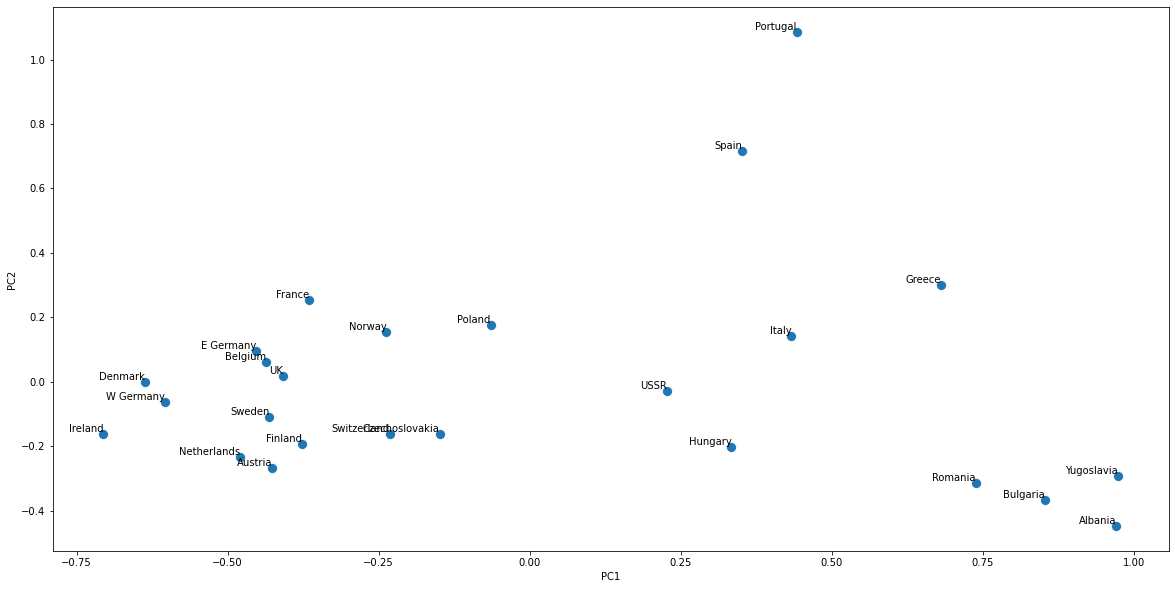

In [6]:
data = pd.read_csv('data/protein.csv')
x = data.drop(['Country'], axis=1)

scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)

pca = PCA(n_components=2)
x_reduced = pca.fit_transform(x_scaled)

x_pca = pd.DataFrame(x_reduced)
x_pca['Country'] = data['Country']

plt.figure(figsize=(20, 10))
ax = sns.scatterplot(x_pca[0], x_pca[1], s=100)
ax.set(xlabel='PC1', ylabel='PC2')

x = x_pca[0]
y = x_pca[1]
names = x_pca['Country']

texts = [plt.text(x0,y0,name,ha='right',va='bottom') for x0,y0,name in zip(x,y,names)]

plt.show()

## MDS

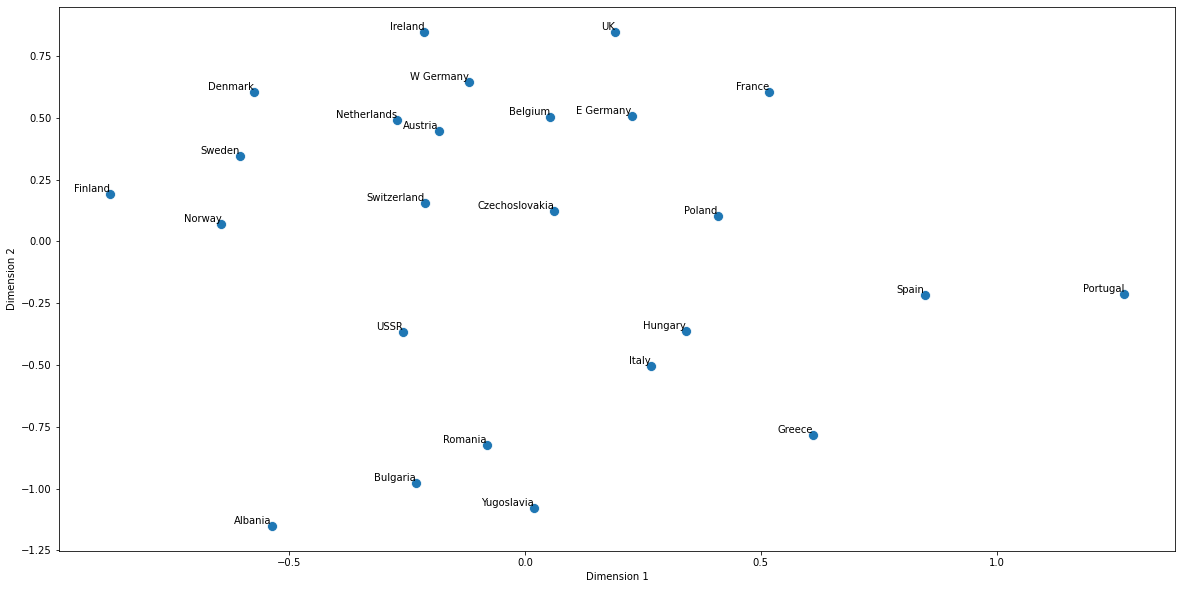

In [5]:
data = pd.read_csv('data/protein.csv')
x = data.drop(['Country'], axis=1)

scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)

mds = MDS(n_components = 2)
x_2d = mds.fit_transform(x_scaled)
x_r = pd.DataFrame(x_2d)
x_r['Country'] = data['Country']

plt.figure(figsize=(20, 10))
ax = sns.scatterplot(x_r[0], x_r[1], s=100)
ax.set(xlabel='Dimension 1', ylabel='Dimension 2')

x = x_r[0]
y = x_r[1]
names = x_r['Country']

texts = [plt.text(x0,y0,name,ha='right',va='bottom') for x0,y0,name in zip(x,y,names)]

plt.show()